# Paired Formality Linear Probes

This notebook generates formal or informal text pairs from partially labeled data. It uses the OpenAI API to construct a dataset where formality is the only varying factor, allowing to test whether formality level can be linearly decoded from representations — without content acting as a confounding variable.

## Resources
* OpenAI API: https://platform.openai.com/docs/overview

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import transformers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from llm_style.formality_dataset import FormalityDataset, PavlickFormalityDataset
from llm_style.paired_formality_dataset import PairedFormalityDataset

In [ ]:
dataset = PavlickFormalityDataset(mode="filtered")
api_key = api_key=""
chatbot_dataset = PairedFormalityDataset(api_key=api_key)

README.md:   0%|          | 0.00/2.90k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/937k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/202k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9274 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
# Extract texts and labels from the dataset
texts = []
labels = []
for i in range(0, 250):
    # if i >= len(dataset):
    #     break
    sample = dataset[i]
    if sample is None:
        continue
    elif "text" not in sample or "label" not in sample:
        print(f"Skipping index {i} due to missing fields.")
        continue
    texts.append(sample["text"])
    labels.append(sample["label"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)
X_dataset = list(zip(X_train, y_train))

In [5]:
generated_dataset = []
for i in range(len(X_dataset)):
    sample = X_dataset[i]
    prompt = X_dataset[i][0]
    label = X_dataset[i][1]
    
    # Generate its pair
    pairs = chatbot_dataset.get_formality_pairs(formality_type=label, prompt=prompt)
    
    generated_dataset.append(pairs)

X_generated_train = [pair[0] for pair in generated_dataset for pair in pair]
y_generated_train = [pair[1] for pair in generated_dataset for pair in pair]

# Export the generated dataset to a CSV file
generated_df = pd.DataFrame({
    "text": X_generated_train,
    "label": y_generated_train
})
generated_df.to_csv("generated_dataset.csv", index=False)

In [6]:
# Get device for computation
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

pipeline = transformers.pipeline(
    "text-generation",
    model="microsoft/phi-4",
    model_kwargs={"torch_dtype": "auto"},
    device_map="auto",
)

Using device: cuda


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use cuda:0


In [7]:
# Define a function to extract features from text
def extract_features(model, tokenizer, texts, layer_idx):
    # Move model to the correct device if not already there
    model_device = next(model.parameters()).device
    if model_device != device:
        model = model.to(device)

    features = []
    batch_size = 16  # Adjust based on your GPU/memory

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        # Tokenize the texts
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get model outputs with no gradient computation
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Extract hidden states from the specified layer
        # For phi-4 model, access the proper hidden states format
        if hasattr(outputs, "hidden_states"):
            hidden_states = outputs.hidden_states[layer_idx]
        else:
            # If hidden_states is a tuple, access it directly
            hidden_states = outputs[2][layer_idx]
        hidden_states = hidden_states.to(torch.float32)

        # Average across the token dimension to get a fixed-size representation
        batch_features = hidden_states.mean(dim=1)
        batch_features_cpu = batch_features.cpu().numpy()
        features.append(batch_features_cpu)

    return np.vstack(features)


# Define a function to perform linear probing for a specified layer
def linear_probe_layer(model, tokenizer, X_train, y_train, X_test, y_test, layer_idx):
    # Extract features for training and testing sets
    train_features = extract_features(model, tokenizer, X_train, layer_idx)
    test_features = extract_features(model, tokenizer, X_test, layer_idx)

    # Convert string labels to binary (1 for formal, 0 for informal)
    y_train_binary = y_train
    y_test_binary = y_test

    # Train a logistic regression classifier
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(train_features, y_train_binary)

    # Evaluate on training and testing data
    train_preds = clf.predict(train_features)
    test_preds = clf.predict(test_features)

    train_acc = accuracy_score(y_train_binary, train_preds)
    test_acc = accuracy_score(y_test_binary, test_preds)

    return {"layer": layer_idx, "train_accuracy": train_acc, "test_accuracy": test_acc}


# Define a function to perform linear probing across all layers
def linear_probe_all_layers(model, tokenizer, X_train, y_train, X_test, y_test):
    results = []
    num_layers = model.config.num_hidden_layers + 1  # +1 for the embedding layer

    for layer_idx in range(num_layers):
        print(f"Probing layer {layer_idx}/{num_layers - 1}...")
        result = linear_probe_layer(
            model, tokenizer, X_train, y_train, X_test, y_test, layer_idx
        )
        results.append(result)
        print(
            f"Layer {layer_idx}: Train acc = {result['train_accuracy']:.4f}, Test acc = {result['test_accuracy']:.4f}"
        )

    return results

In [8]:
# Perform linear probing across all layers
probe_results = linear_probe_all_layers(pipeline.model, pipeline.tokenizer, X_generated_train, y_generated_train, X_test, y_test)

Probing layer 0/40...
Layer 0: Train acc = 0.5898, Test acc = 0.7812
Probing layer 1/40...
Layer 1: Train acc = 0.8242, Test acc = 0.8125
Probing layer 2/40...
Layer 2: Train acc = 0.8984, Test acc = 0.7812
Probing layer 3/40...
Layer 3: Train acc = 0.9570, Test acc = 0.8125
Probing layer 4/40...
Layer 4: Train acc = 0.9844, Test acc = 0.7500
Probing layer 5/40...
Layer 5: Train acc = 0.9922, Test acc = 0.7188
Probing layer 6/40...
Layer 6: Train acc = 1.0000, Test acc = 0.7500
Probing layer 7/40...
Layer 7: Train acc = 1.0000, Test acc = 0.8125
Probing layer 8/40...
Layer 8: Train acc = 1.0000, Test acc = 0.8125
Probing layer 9/40...
Layer 9: Train acc = 1.0000, Test acc = 0.7812
Probing layer 10/40...
Layer 10: Train acc = 1.0000, Test acc = 0.8125
Probing layer 11/40...
Layer 11: Train acc = 1.0000, Test acc = 0.8438
Probing layer 12/40...
Layer 12: Train acc = 1.0000, Test acc = 0.8438
Probing layer 13/40...
Layer 13: Train acc = 1.0000, Test acc = 0.7812
Probing layer 14/40...
Lay

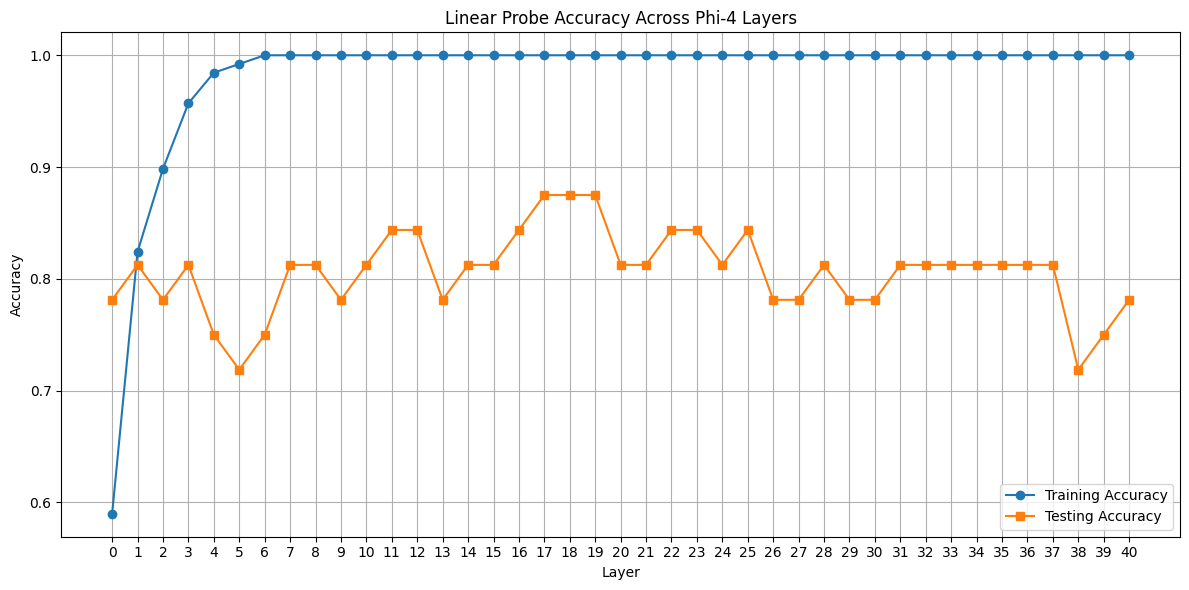

In [9]:
# Extract results for plotting
layers = [result["layer"] for result in probe_results]
train_accs = [result["train_accuracy"] for result in probe_results]
test_accs = [result["test_accuracy"] for result in probe_results]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(layers, train_accs, marker='o', label='Training Accuracy')
plt.plot(layers, test_accs, marker='s', label='Testing Accuracy')
plt.title('Linear Probe Accuracy Across Phi-4 Layers')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.xticks(layers)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Analysis of Results

In [10]:
# Find the layer with the best test accuracy
best_layer_idx = np.argmax(test_accs)
best_layer = layers[best_layer_idx]
best_accuracy = test_accs[best_layer_idx]

print(f"Best performance at layer {best_layer} with test accuracy: {best_accuracy:.4f}")

Best performance at layer 17 with test accuracy: 0.8750
